<a href="https://colab.research.google.com/github/Indukurivigneshvarma/Deep_Learning/blob/main/Time_Series/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)

df.columns = df.columns.str.strip().str.capitalize()

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')

In [4]:
print("Missing values before fix:", df['Temp'].isna().sum())

df['Temp'] = df['Temp'].fillna(method='ffill')

print("Missing values after fix:", df['Temp'].isna().sum())

Missing values before fix: 2
Missing values after fix: 0


/tmp/ipython-input-832157111.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Temp'] = df['Temp'].fillna(method='ffill')


In [5]:
data = df[['Temp']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
def create_dataset(dataset, time_step=30):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_dataset(scaled_data, time_step)

In [7]:
X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(time_step, 1)),
    GRU(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0415 - val_loss: 0.0103
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0111 - val_loss: 0.0085
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0108 - val_loss: 0.0078
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0097 - val_loss: 0.0077
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0093 - val_loss: 0.0072
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0090 - val_loss: 0.0080
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0089 - val_loss: 0.0071
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0091 - val_loss: 0.0073
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.

In [10]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [11]:
mae = mean_absolute_error(y_test_inv, test_pred)
rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred))
print("====================================")
print("GRU MODEL PERFORMANCE")
print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("====================================")

GRU MODEL PERFORMANCE
MAE : 1.74
RMSE: 2.21


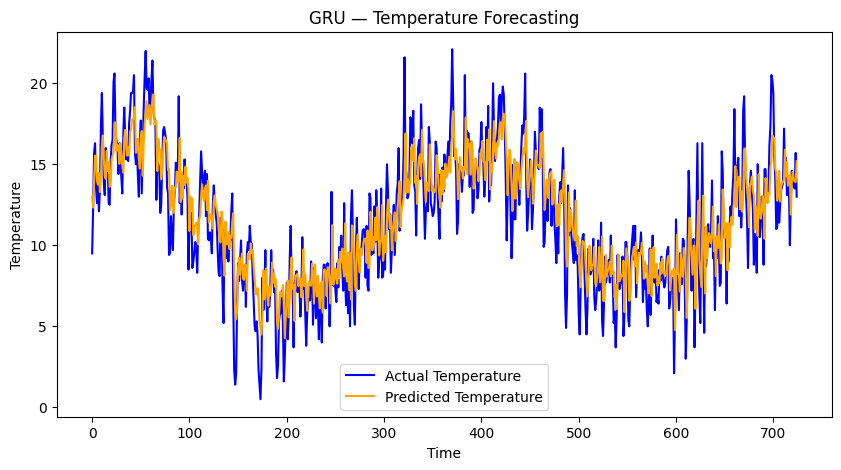

In [12]:
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Temperature', color='blue')
plt.plot(test_pred, label='Predicted Temperature', color='orange')
plt.title('GRU — Temperature Forecasting')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━

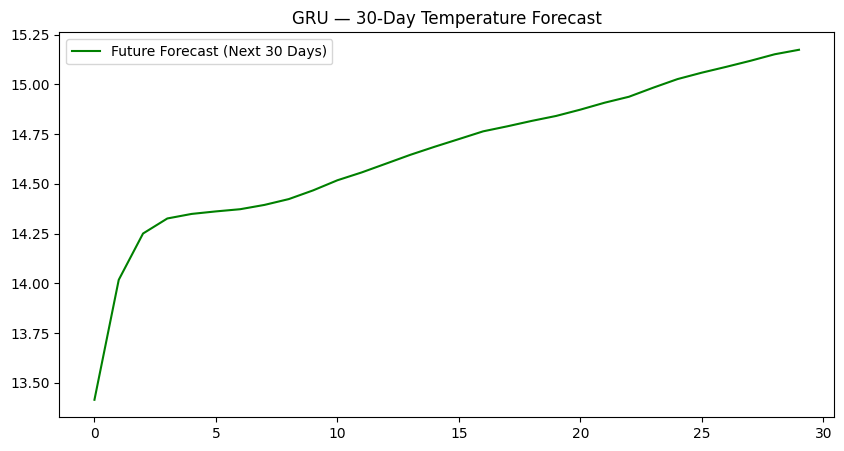

In [14]:
last_sequence = scaled_data[-time_step:]
future_pred = []

for _ in range(30):
    seq_input = last_sequence.reshape(1, time_step, 1)
    next_pred = model.predict(seq_input)
    future_pred.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

future_pred = scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(future_pred, label='Future Forecast (Next 30 Days)', color='green')
plt.title('GRU — 30-Day Temperature Forecast')
plt.legend()
plt.show()